In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn import datasets
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from typing import Tuple, List
from sklearn.preprocessing import MinMaxScaler
import warnings
import scipy
import numba as nb
import requests
import sys

sys.path.insert(1, "./umap")
warnings.filterwarnings('always')

def visualize(x, y, axis):
    colors = cm.rainbow(np.linspace(0, 1, max(y) - min(y) + 1))
    for sample_index in range(len(x)):
        sample = x[sample_index]
        label = y[sample_index]
        axis.scatter(sample[0], sample[1], color=colors[label], s=10)

def visualize_loss(function):
    X = np.arange(0.1, 0.9, 0.1)
    Y = np.arange(0.1, 0.9, 0.1)
    X = np.exp(-X ** 2) + 1e-8
    Y = 1 / ((1 + Y ** 2) + 1e-8) + 1e-8
    X, Y = np.meshgrid(X, Y)
    Z = function(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.view_init(azim=30)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def evaluate_visualizations(
    min_neighbors: int,
    max_neighbors: int,
    low_dimension_factory,
    show_cross_entropy: bool = False,
    one_run: bool = False):
    def evaluate_umap(axis, neighbors: List[int]):
        print(f'Running UMAP for neighbors count: {neighbors}')
        axis.set_title(f'Neighbors: {neighbors}')
        response = low_dimension_factory(neighbors)
        visualize(response[0], labels, axis)
        y = MinMaxScaler().fit_transform(response[0])
        return response
    figure, axes = plt.subplots(2, 2, figsize=(12, 12))
    evaluate_umap(axes[0, 0], [min_neighbors])
    if one_run:
        return []
    evaluate_umap(axes[0, 1], [max_neighbors])
    response = evaluate_umap(axes[1, 0], [min_neighbors, max_neighbors])
    if len(response) > 1:
        axes[1, 1].plot(response[1], label="Weighted Cross Entropy")
        axes[1, 1].legend()
    if len(response) > 2 and show_cross_entropy:
        axes[1, 1].plot(response[2], label="Cross Entropy")
        axes[1, 1].legend()
    return response[1] if len(response) > 1 else None

dataset = datasets.make_moons(n_samples=1500, noise=0.05)
labels = dataset[1] #[0:200]
digits = dataset[0] #[0:200]
digits.shape

(1500, 2)

## Parameters

In [2]:
distances = euclidean_distances(digits, digits)
MIN_NEIGHBORS = 5
MAX_NEIGHBORS = 10
FULL_MIN_NEIGHBORS = int(len(digits) / 2)
FULL_MAX_NEIGHBORS = len(digits)
MIN_DIST = 1.0
ITERATION_LIMIT = 150

## L1. Fuzzy Cross Entropy

/data/umap/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


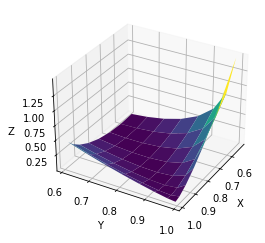

In [3]:
from algorithm import umap, GradientOptimizer, Adam, CrossEntropyLoss
visualize_loss(lambda P, Q: P * np.log(P / Q) + (1 - P) * np.log((1 - P) / (1 - Q)))

Running UMAP for neighbors count: [10]


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[1]: loss 874418.1228646785
[50]: loss 28601.071072468178
[100]: loss 21188.157345920234
[150]: loss 19573.982583243207
Running UMAP for neighbors count: [1500]
[1]: loss 6738477.585822121
[50]: loss 1129009.7900029882
[100]: loss 1072978.8636423182
[150]: loss 1072566.274012229
Running UMAP for neighbors count: [10, 1500]
[1]: loss 4324536.902304638
[50]: loss 2079854.8533507765
[100]: loss 2050626.1269239218
[150]: loss 2050717.8303945682
CPU times: user 9min 24s, sys: 21 s, total: 9min 45s
Wall time: 4min 2s


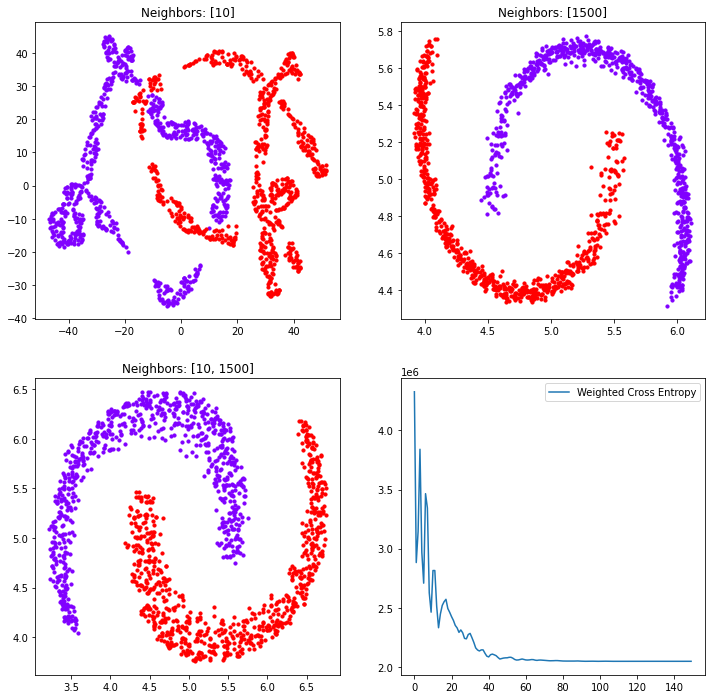

In [4]:
%%time
cel = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=CrossEntropyLoss())))

## L2. Symmetric Fuzzy Cross Entropy

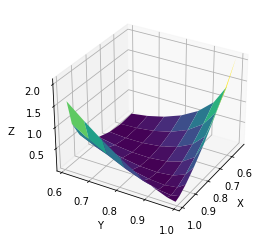

In [5]:
from algorithm import SymmetricLoss
visualize_loss(lambda P, Q: (P - Q) * np.log((P * (1 - Q)) / (Q * (1 - P))))

Running UMAP for neighbors count: [10]
[1]: loss 5195531.864272068
[50]: loss 128536.95086757981
[100]: loss 104015.07160225585
[150]: loss 98698.68145885644
Running UMAP for neighbors count: [1500]
[1]: loss 8720899.964911936
[50]: loss 191139.59950471195
[100]: loss 117829.78828847695
[150]: loss 117511.19733081516
Running UMAP for neighbors count: [10, 1500]
[1]: loss 3927570.352956167
[50]: loss 914392.40769197
[100]: loss 910804.6977062308
[150]: loss 910200.3862841458
CPU times: user 8min 49s, sys: 30.7 s, total: 9min 20s
Wall time: 3min 40s


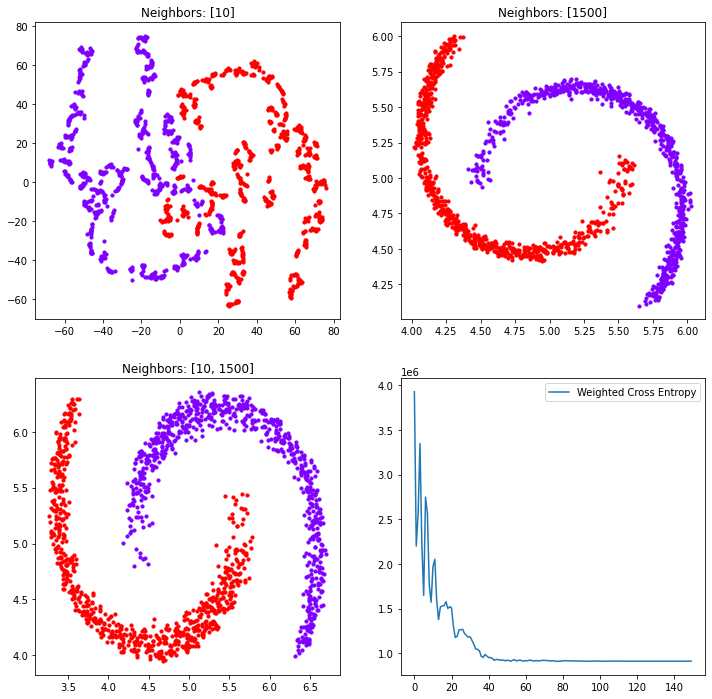

In [6]:
%%time
sl = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=SymmetricLoss())))

## L3. Intuitionistic Fuzzy Cross Entropy

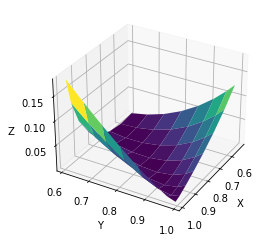

In [7]:
from algorithm import IntuitionisticLoss
visualize_loss(lambda P, Q: P * np.log(P / (0.5*P + 0.5*Q)) + (1 - P)*np.log((1 - P) / (1 - 0.5*(P + Q))))

Running UMAP for neighbors count: [10]
[1]: loss 109436.38012822
[50]: loss 7965.499646229225
[100]: loss 7532.9110084431395
[150]: loss 7341.26737636471
Running UMAP for neighbors count: [1500]
[1]: loss 1670575.5791075185
[50]: loss 1061944.1622579878
[100]: loss 1010091.9447179246
[150]: loss 1003946.4289466986
Running UMAP for neighbors count: [10, 1500]
[1]: loss 1703903.2821285923
[50]: loss 1499972.7618200684
[100]: loss 1491095.1962329864
[150]: loss 1486513.1016481523
CPU times: user 9min 1s, sys: 29.2 s, total: 9min 31s
Wall time: 3min 35s


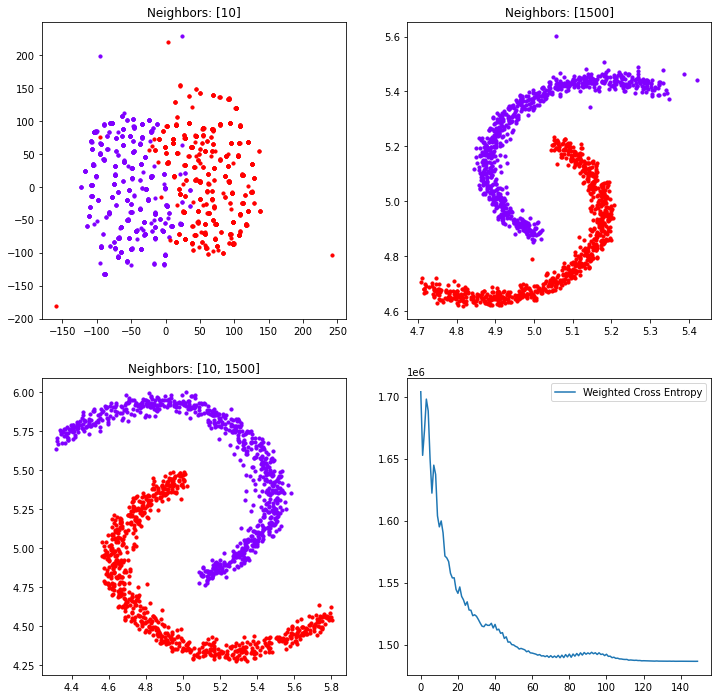

In [8]:
%%time
il = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=0.1 * MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=IntuitionisticLoss())))

## L4. Weighted Fuzzy Cross Entropy

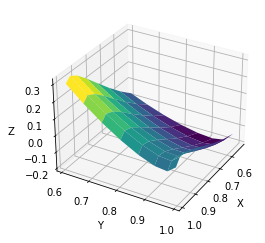

In [9]:
visualize_loss(lambda P, Q: P * np.log(P / Q) + 0.05 * np.log((1 - P) / (1 - Q)))

Running UMAP for neighbors count: [10]
[1]: loss 3737.375456347108
[50]: loss 1528.4517697470694
[100]: loss 1126.478736593519
[150]: loss 1058.7149847448813
Running UMAP for neighbors count: [1500]
[1]: loss 7059324.299610655
[50]: loss 2647811.545719985
[100]: loss 2639531.2923345193
[150]: loss 2638684.86355338
Running UMAP for neighbors count: [10, 1500]
[1]: loss 4324074.678126717
[50]: loss 1611938.6137617496
[100]: loss 1588717.4792470254
[150]: loss 1588481.7118421055
CPU times: user 9min 16s, sys: 19.6 s, total: 9min 36s
Wall time: 3min 47s


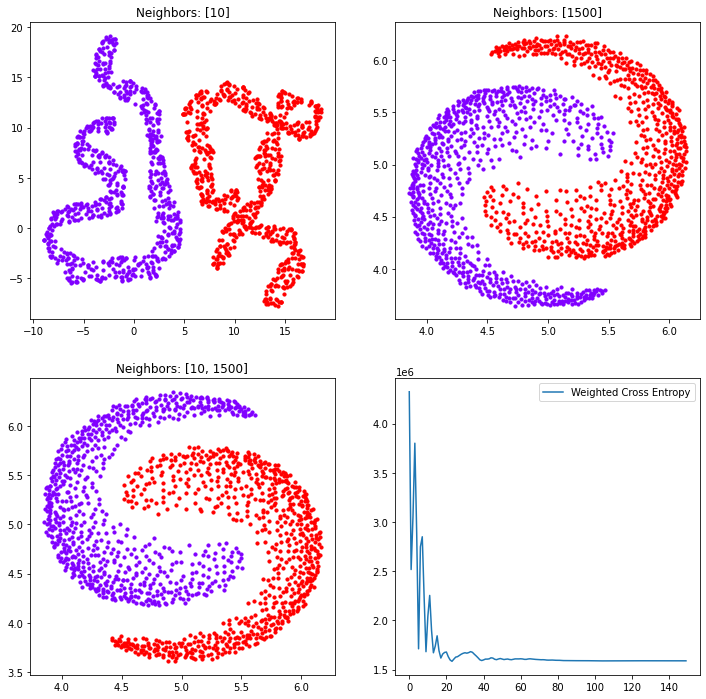

In [10]:
%%time
cel = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=CrossEntropyLoss(reduce_repulsion=True))))

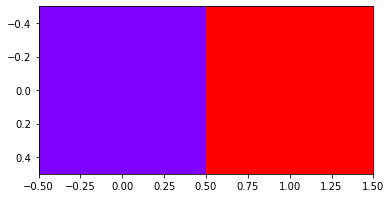

In [11]:
plt.imshow([cm.rainbow(np.linspace(0, 1, max(labels) - min(labels) + 1))])